### Дано:

* Тренировочные данные состоят из 323 наблюдений, в каждом из которых есть 40 сигналов датчиков снятые 100 раз с равными промежутками времени.

* Тренировочные данные получены следующим образом: пилоту показываю жест - пилот повторяет жест (всё это время датчики регистрирую какие-то параметры) логично, что между командой на выполнение жеста и самим жестом проходит како-то время ($\Delta t$) 

### Задача: 
* Определить какой из 8ми жестов был показан в тестовых наблюдениях

### Проблема: 
* Существует изменяющаяся от наблюдения к наблюдению задержка между "жестом" и его регистрацией датчиками

### Метрика:
* Mean F-score

### Методика:

1. Определим ключевые датчики
2. Определим задержку 
3. Подготовим данные к загрузке в модель
4. Обучим модель
5. Подготовим submission

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt

### 0. Загрузим данные

In [902]:
data_train = np.load('X_train.npy')
data_test = np.load('X_test.npy')
data_y_train = pd.read_csv('y_train.csv')

print('Форма данных на входе:')
print(data_train.shape, data_y_train.shape, data_test.shape)

# Поменяем местами время и датчики 
data_train = data_train.swapaxes(1, 2)
data_test = data_test.swapaxes(1, 2)

# Преобразуем массивы в pd.DataFrame
lst_1 = []
for i in np.arange(data_train.shape[0]):
    lst_1.extend(data_train[i])
    
lst_2 = []
for i in np.arange(data_test.shape[0]):
    lst_2.extend(data_test[i])
    
data_train = pd.DataFrame(np.array(lst_1))
data_test = pd.DataFrame(np.array(lst_2))

# Добавим в тестовый сет данные о классах
data_train = data_train.join(data_y_train, how='left')
data_train['sample'] = data_train['sample-timestep'].apply(lambda x: x.split('-', 1)[0]).astype(int)
data_train['time'] = data_train['sample-timestep'].apply(lambda x: x.split('-', 1)[1]).astype(int)

print('Форма данных после предобработки:')
print(data_train.shape, data_test.shape)

Форма данных на входе:
(323, 40, 100) (32300, 2) (54, 40, 100)
Форма данных после предобработки:
(32300, 44) (5400, 40)


### 1. Определим ключевые датчики

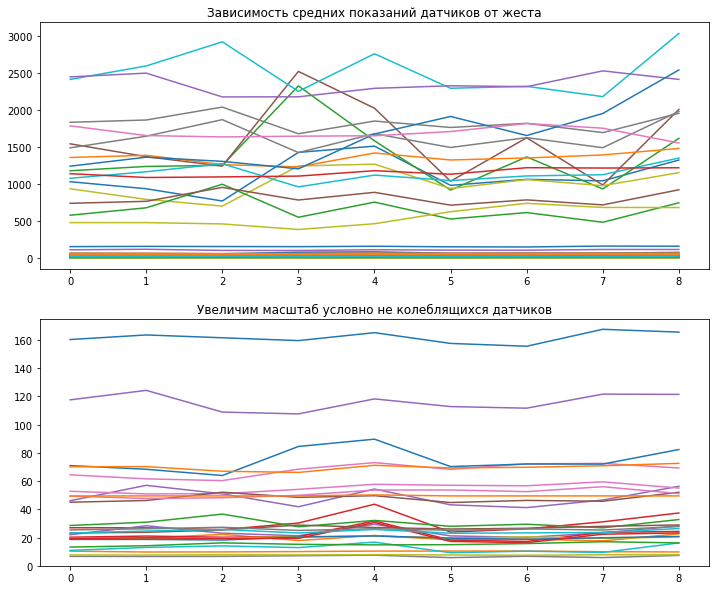

In [903]:
fig, axx = plt.subplots(2, 1, figsize=(12, 10))
axx[0].plot(data_train.groupby('class').mean())
axx[0].set_title('Зависимость средних показаний датчиков от жеста')

axx[1].plot(data_train.groupby('class').mean())
axx[1].set_title('Увеличим масштаб условно не колеблящихся датчиков')
axx[1].set_ylim(0,175);

In [904]:
# Определим "неинформативные" датчики
col_to_drop = []
for i in np.arange(40):
    if data_train[i].mean() < 200:
        col_to_drop.append(i)
        
# И дропнем их из данных
data_train = data_train.drop(col_to_drop, axis=1)
data_test = data_test.drop(col_to_drop, axis=1)

### 2. Определим задержку по ответам

In [914]:
# Добавим столбец содержащий процентное изменение среднего значения датчиков за каждый шаг
data_train['change'] = data_train[[0,2,5,8,12,15,17,19,21,24,27,29,30,33,36,38]].mean(axis=1).pct_change().fillna(0)

data_train['slide'] = data_train[[0,2,5,8,12,15,17,19,21,24,27,29,30,33,36,38]].rolling(window=5).std().fillna(0).sum()

# Определим функцию компенсирующую задержку ответа
def shift_fixer(data_train, n=0.006):
    res = []
    for i in np.arange(data_train['sample'].max()+1):
        data = data_train[['change', 'class', 'sample']][data_train['sample'] == i]
        curr_class = data['class'].iloc[0]
        for j in np.arange(100):
            if abs(data['change'].iloc[j]) < n:
                res.append(curr_class)
            else:
                curr_class = data['class'].iloc[j]
                res.append(curr_class)
    return res

# Определим функцию компенсирующую задержку ответа по скользящему среднему
def shift_slider(data_train, n=530):
    res = []
    for i in np.arange(data_train['sample'].max()+1):
        data = data_train.drop(['sample-timestep','sample','time'], axis=1)[data_train['sample'] == i]
        curr_class = data['class'].iloc[0]
        for j in np.arange(100):
            if data.rolling(window=5).std().fillna(0).iloc[j].sum() < n:
                res.append(curr_class)
            else:
                curr_class = data['class'].iloc[j]
                res.append(curr_class)
    return res   
    

# Добавим исправленные ответы (с компенсированной задержкой)
data_train['fixed_class'] = shift_slider(data_train)

### 3. Подготовим данные к моделированию

C:\Users\AubakirovMA\AppData\Local\Temp\ipykernel_13624\3229256312.py:20: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['sample-timestep'], dtype='object')
  axx[3].plot(data_train.rolling(window=5).std().fillna(0)[data_train['sample'] == i]);


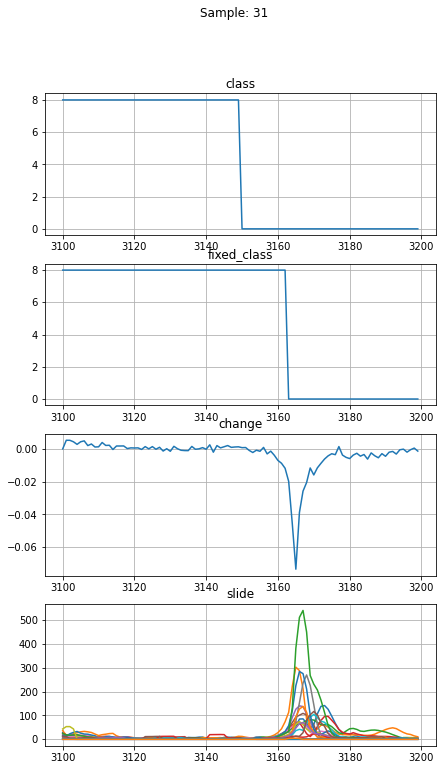

In [915]:
i = np.random.randint(323)
#i = 207
fig, axx = plt.subplots(nrows=4, figsize=(7, 12))
plt.suptitle(f'Sample: {i}');

axx[0].set_title('class')
axx[0].grid()
axx[0].plot(data_train['class'][data_train['sample'] == i])

axx[1].set_title('fixed_class')
axx[1].grid()
axx[1].plot(data_train['fixed_class'][data_train['sample'] == i])

axx[2].set_title('change')
axx[2].grid()
axx[2].plot(data_train['change'][data_train['sample'] == i])

axx[3].set_title('slide')
axx[3].grid()
axx[3].plot(data_train.rolling(window=5).std().fillna(0)[data_train['sample'] == i]);

In [916]:
X = data_train.drop(['sample-timestep','class','sample','time','change', 'fixed_class', 'slide'], axis=1)
X_sub = data_test
y = data_train['fixed_class']

# Выполним разбивку
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

# Отмасштабируем данные
scaler = StandardScaler()
scaler.fit(X)

X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_sub = scaler.transform(X_sub)
X_scaled = scaler.transform(X)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((25840, 16), (25840,), (6460, 16), (6460,))

In [917]:
# Подготовом сеты данных
train_dataset = lgb.Dataset(X_train, y_train)
test_dataset = lgb.Dataset(X_valid, y_valid)

# потренируем модель
booster = lgb.train({"objective": "multiclass", "num_class":9, "verbosity": -1},
                    train_set=train_dataset, valid_sets=(test_dataset,),
                    num_boost_round=200)

# Сделаем предсказания
train_preds = booster.predict(X_train)
valid_preds = booster.predict(X_valid)
set_preds = booster.predict(X_scaled)

train_preds = np.argmax(train_preds, axis=1)
valid_preds = np.argmax(valid_preds, axis=1)
set_preds = np.argmax(set_preds, axis=1)

# Выведем метрику
print("\nTrain F1: %.6f"%f1_score(y_train, train_preds, average="macro"))
print("Valid F1: %.6f"%f1_score(y_valid, valid_preds, average="macro"))
print("Whole set F1: %.6f"%f1_score(y, set_preds, average="macro"))

[1]	valid_0's multi_logloss: 0.871206
[2]	valid_0's multi_logloss: 0.696481
[3]	valid_0's multi_logloss: 0.5726
[4]	valid_0's multi_logloss: 0.478458
[5]	valid_0's multi_logloss: 0.404836
[6]	valid_0's multi_logloss: 0.345857
[7]	valid_0's multi_logloss: 0.297329
[8]	valid_0's multi_logloss: 0.257348
[9]	valid_0's multi_logloss: 0.223874
[10]	valid_0's multi_logloss: 0.196211
[11]	valid_0's multi_logloss: 0.172778
[12]	valid_0's multi_logloss: 0.153249
[13]	valid_0's multi_logloss: 0.136721
[14]	valid_0's multi_logloss: 0.122542
[15]	valid_0's multi_logloss: 0.110616
[16]	valid_0's multi_logloss: 0.100052
[17]	valid_0's multi_logloss: 0.0911303
[18]	valid_0's multi_logloss: 0.0834017
[19]	valid_0's multi_logloss: 0.0771029
[20]	valid_0's multi_logloss: 0.0715949
[21]	valid_0's multi_logloss: 0.066519
[22]	valid_0's multi_logloss: 0.0621111
[23]	valid_0's multi_logloss: 0.0582468
[24]	valid_0's multi_logloss: 0.0550767
[25]	valid_0's multi_logloss: 0.0524986
[26]	valid_0's multi_logloss

In [918]:
# Выполним предсказания для тестовых данных
y_sub = booster.predict(X_sub)
y_sub = np.argmax(y_sub, axis=1)

# Добавим сглаживатель предсказаний
from statistics import mode

def smooth_row(row, mode_value=7):
    smoothing_row = []
    for k in range(len(row)):
        smoothing_row.append(mode(row[k:(k + mode_value)]))
    len(smoothing_row)
    return smoothing_row
   
# Запишем предсказания в требуемый Kaggle вид
data_y_test = pd.read_csv('sample_submission.csv')
data_y_test['class'] = y_sub
data_y_test['class'] = smooth_row(data_y_test['class'])
data_y_test.set_index('sample-timestep', inplace=True)
data_y_test.to_csv('sample_submission.csv')

### Private Score: 0,97185

### Public Score: 0,97407

C:\Users\AubakirovMA\AppData\Local\Temp\ipykernel_13624\3414297860.py:24: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['sample-timestep'], dtype='object')
  axx[3].plot(data_train.rolling(window=5).std().fillna(0)[data_train['sample'] == i]);


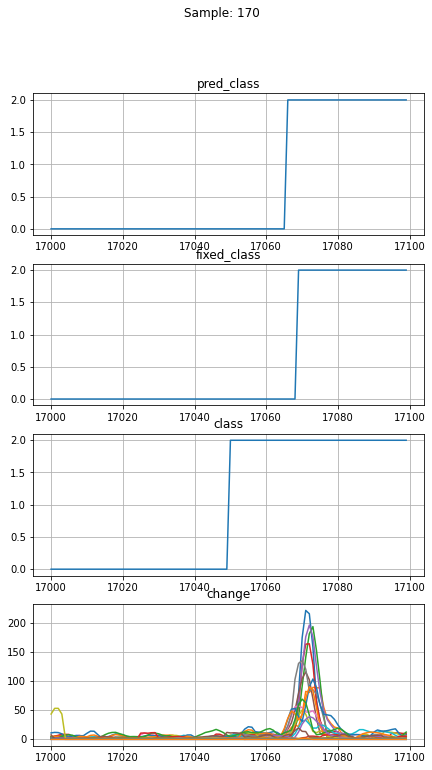

In [920]:
plot_data = data_train.copy()
plot_data['pred_class'] = set_preds
plot_data['pred_class'] = smooth_row(plot_data['pred_class'])

i = np.random.randint(323)

fig, axx = plt.subplots(nrows=4, figsize=(7, 12))
plt.suptitle(f'Sample: {i}')

axx[0].set_title('pred_class')
axx[0].grid()
axx[0].plot(plot_data['pred_class'][plot_data['sample'] == i])

axx[1].set_title('fixed_class')
axx[1].grid()
axx[1].plot(plot_data['fixed_class'][plot_data['sample'] == i])

axx[2].set_title('class')
axx[2].grid()
axx[2].plot(plot_data['class'][plot_data['sample'] == i])

axx[3].set_title('change')
axx[3].grid()
axx[3].plot(data_train.rolling(window=5).std().fillna(0)[data_train['sample'] == i]);